# 이미지 분류기 프로젝트 (tensorflow 학습용으로 만든 프로젝트)

In [1]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.ylabel('MSE')
    plt.xlabel('epochs')

In [2]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tf.__version__

'2.15.0'

In [ ]:
# fashion_mnist 데이터셋을 훈련 세트와 테스트 세트로 분리하여 로드
# X_train_full: 전체 훈련 이미지 데이터
# y_train_full: 전체 훈련 이미지에 대한 레이블
# X_test: 테스트 이미지 데이터
# y_test: 테스트 이미지에 대한 레이블

fashion_mnist = keras.datasets.fashion_mnist  # 패션 MNIST 데이터셋을 로드 (28x28 픽셀의 흑백 이미지, 10개의 클래스)
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


훈련 세트는 60,000개의 흑백 이미지이고, 각 이미지의 크기는 28x28 픽셀이다:

In [5]:
X_train_full.shape

(60000, 28, 28)

데이터 분할을 위해 전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나누고
데이터 정규화를 위해 픽셀 강도를 255로 나누어 0~1 범위의 실수(real number)로 바꿔야함

In [ ]:
# 훈련 데이터(X_train_full)를 검증 세트(X_valid)와 훈련 세트(X_train)로 분리
# X_train_full[:5000]: 처음 5000개의 데이터를 검증 세트로 사용 (픽셀 값을 0~1 사이로 정규화)
# X_train_full[5000:]: 나머지 데이터를 훈련 세트로 사용 (픽셀 값을 0~1 사이로 정규화)
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.

# 훈련 레이블(y_train_full)을 검증 세트(y_valid)와 훈련 세트(y_train)로 분리
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# 테스트 세트(X_test)도 0~1 사이로 정규화 (픽셀 값을 255로 나누어 정규화)
X_test = X_test / 255.

In [8]:
X_train = X_train_full[5000:] / 255.
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.17254902, 0.49803922, 0.71372549, 0.7254902 ,
        0.63137255, 0.47058824, 0.21568627, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16470588,
        0.77647059, 0.98431373, 1.        , 0.98431373, 0.97647059,
        0.96862745, 1.    

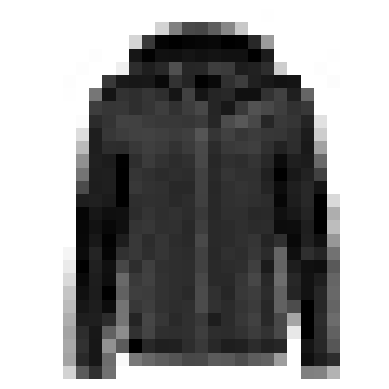

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디(id)이다:

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

분류할 클래스 이름들을 나열

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

샘플 이미지 출력

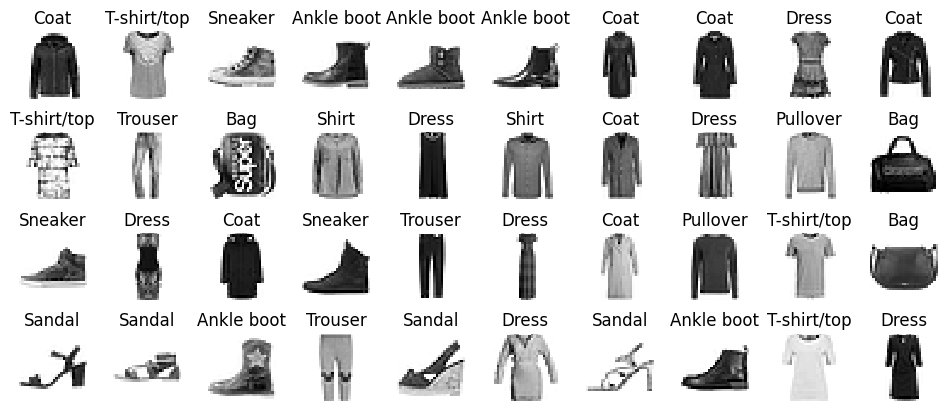

In [15]:
n_rows = 4  # 출력할 이미지의 행(row) 수
n_cols = 10  # 출력할 이미지의 열(column) 수
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))  # 전체 그림의 크기를 설정 (가로와 세로 비율 조정)

for row in range(n_rows):  # 각 행에 대해 반복
    for col in range(n_cols):  # 각 열에 대해 반복
        index = n_cols * row + col  # 각 이미지의 인덱스 계산
        plt.subplot(n_rows, n_cols, index + 1)  # 서브플롯을 생성 (4x10 레이아웃에 이미지를 배치)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")  # X_train에서 이미지를 가져와 이진(binary) 색상으로 출력
        plt.axis('off')  # 축을 비활성화하여 깔끔한 이미지 출력
        plt.title(class_names[y_train[index]], fontsize=12)  # 이미지 위에 해당 클래스 이름을 표시

plt.subplots_adjust(wspace=0.2, hspace=0.5)  # 서브플롯 간의 가로, 세로 간격 조정
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()  # 생성된 이미지를 화면에 출력


In [16]:
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),  # 입력 데이터를 1차원 벡터로 변환하는 Flatten 레이어 (28x28 이미지를 펼침)
    keras.layers.Dense(300, activation="relu"),  # 300개의 뉴런을 가진 Dense 레이어, ReLU 활성화 함수 사용
    keras.layers.Dense(100, activation="relu"),  # 100개의 뉴런을 가진 Dense 레이어, ReLU 활성화 함수 사용
    keras.layers.Dense(10, activation="softmax") # 10개의 뉴런을 가진 출력층, softmax 활성화 함수 사용 (다중 클래스 분류)
])


In [18]:
h= model.layers[0]
h

In [19]:
model.layers

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Flatten: 다차원 데이터를 1차원 벡터로 변환하는 레이어.


Dense: 신경망에서 모든 입력 뉴런과 출력 뉴런이 완전히 연결된 레이어로, 가중치를 학습하여 예측을 수행하는 핵심 레이어.

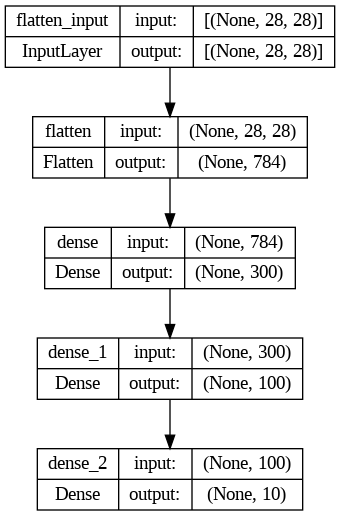

In [21]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [22]:
hidden1 = model.layers[1]
print(hidden1)
print(hidden1.name)

dense


In [23]:
model.get_layer('flatten')

In [24]:
model.get_layer('dense')

In [25]:
model.get_layer(hidden1.name) is hidden1

True

In [26]:
weights, biases = hidden1.get_weights()

In [27]:
weights

array([[-0.01769766,  0.06723645, -0.07246545, ...,  0.03089665,
        -0.05066   , -0.04126167],
       [-0.06887997, -0.01179095,  0.07033262, ..., -0.03450217,
         0.01917403,  0.01810709],
       [-0.03810258, -0.04412942, -0.00033744, ..., -0.0025503 ,
        -0.05672675, -0.03727211],
       ...,
       [ 0.00675113,  0.0527173 , -0.05718885, ...,  0.07430601,
         0.02835082,  0.05347224],
       [ 0.06429374,  0.0525482 , -0.03745351, ..., -0.0650167 ,
        -0.05736915, -0.06974889],
       [-0.01681247, -0.05888068,  0.03825186, ...,  0.01122031,
         0.07345662, -0.06414219]], dtype=float32)

In [28]:
weights.shape

(784, 300)

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

In [31]:
# 모델을 컴파일하여 학습할 수 있도록 준비
model.compile(
    loss="sparse_categorical_crossentropy",  # 손실 함수로 sparse_categorical_crossentropy 사용: 다중 클래스 분류 문제에 적합
    optimizer="sgd",                         # 옵티마이저로 SGD(확률적 경사 하강법)를 사용하여 가중치 업데이트
    metrics=["accuracy"]                     # 평가 지표로 정확도를 사용하여 학습 중에 정확도를 확인
)


위 코드는 다음과 같다:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [32]:
history = model.fit(X_train, y_train,  # 훈련 데이터와 훈련 레이블을 사용하여 모델을 학습
                    epochs=10,          # 모델을 10번 반복하여 학습
                    batch_size=50,      # 배치 크기를 50으로 설정 (한 번에 50개의 샘플을 처리)
                    validation_data=(X_valid, y_valid))  # 검증 데이터와 검증 레이블을 사용하여 검증 수행


Epoch 1/10
1100/1100 [==============================] - 5s 3ms/step - loss: 0.8156 - accuracy: 0.7393 - val_loss: 0.5540 - val_accuracy: 0.8158
Epoch 2/10
1100/1100 [==============================] - 4s 3ms/step - loss: 0.5228 - accuracy: 0.8215 - val_loss: 0.4752 - val_accuracy: 0.8390
Epoch 3/10
1100/1100 [==============================] - 3s 3ms/step - loss: 0.4726 - accuracy: 0.8351 - val_loss: 0.4703 - val_accuracy: 0.8288
Epoch 4/10
1100/1100 [==============================] - 3s 3ms/step - loss: 0.4435 - accuracy: 0.8461 - val_loss: 0.4227 - val_accuracy: 0.8564
Epoch 5/10
1100/1100 [==============================] - 3s 3ms/step - loss: 0.4242 - accuracy: 0.8524 - val_loss: 0.4029 - val_accuracy: 0.8604
Epoch 6/10
1100/1100 [==============================] - 4s 3ms/step - loss: 0.4077 - accuracy: 0.8579 - val_loss: 0.3963 - val_accuracy: 0.8668
Epoch 7/10
1100/1100 [==============================] - 3s 3ms/step - loss: 0.3957 - accuracy: 0.8630 - val_loss: 0.3882 - val_accuracy:

모델은 10 에포크 동안 학습되었으며, 각 에포크 당 **1,100번의 배치(steps)**로 데이터를 나누어 학습

verbose는 학습 과정 중에 출력할 정보를 자동으로 결정

In [33]:
# history 객체의 파라미터 확인
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1100}

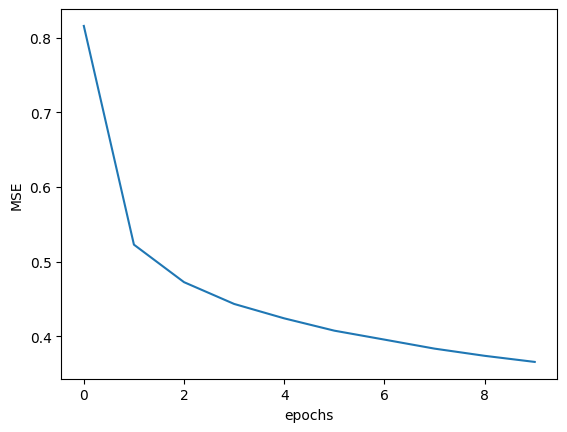

In [34]:
plot_loss(history)  # 학습 과정 동안 손실 값의 변화를 그래프로 시각화

* epochs : 30 => 전체 데이터를 30번 학습을 시켰음.
* steps: 1719 => 각 epoch에서 몇번이나 weights을 업데이트 했는지를 나타냄. 

즉 전체 데이터를 batch로 나누어 수행하여, back propagation을 시행한 횟수이다. 
예를 들어 , 학습을 위해 fit을 수행 할때, batch_size=50을 주면, 한 batch에 50개의 데이터셋을 forward feed한 후 
이에 대한 평균을 가지고 backpropagation을 하게 된다.

In [35]:
history.history.keys()  # 학습 중 기록된 메트릭(손실 및 정확도 등)의 키 목록을 반환

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
history.history['loss']  # 각 에포크(epoch)에서 계산된 훈련 손실 값의 리스트를 반환

[0.8155521750450134,
 0.5228336453437805,
 0.47262102365493774,
 0.4434738755226135,
 0.42417699098587036,
 0.4077078700065613,
 0.3957369327545166,
 0.38366690278053284,
 0.37404900789260864,
 0.3658734858036041]

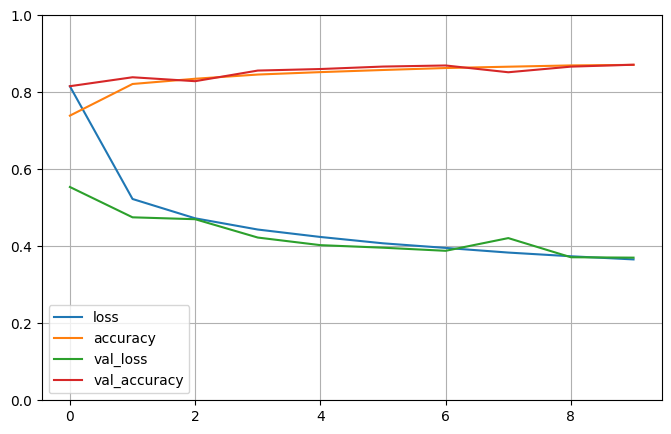

In [37]:
import pandas as pd

# 학습 곡선(에포크에 따른 손실/정확도)
pd.DataFrame(history.history).plot(figsize=(8, 5))

# 플롯에 그리드 추가
plt.grid(True)

# 손실이나 정확도 값을 확인하기 위해 플롯의 y축 범위를 0에서 1로 설정
plt.gca().set_ylim(0, 1)

#save_fig("keras_learning_curves_plot")

plt.show()


In [38]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4084 - accuracy: 0.8569


[0.4084317982196808, 0.8568999767303467]

In [39]:
# 테스트 데이터에서 첫 3개의 샘플을 선택
X_new = X_test[:3]

# 선택한 3개의 샘플에 대해 모델이 각 클래스에 대한 확률을 예측
y_proba = model.predict(X_new)

# 예측된 확률 값을 소수점 두 자리로 반올림하여 출력
y_proba.round(2)

1/1 [==============================] - 0s 76ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.09, 0.  , 0.83],
       [0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

혹은 다음과 같이 예측을 해 볼수 있습니다.


In [40]:
# y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1) # argmax는 배열에서 최대값의 인덱스를 반환하는 함수
y_pred

1/1 [==============================] - 0s 19ms/step


array([9, 2, 1])

In [41]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

**코드 해설** : array에 대한 인덱싱에서, 단일 인덱스를 주는 방법외에 복수의 인덱스를 하나의 array에 넣어 인덱싱 할수 있다.

In [42]:
np.array(class_names)[np.array([1, 9])]

array(['Trouser', 'Ankle boot'], dtype='<U11')

그리고 실제 정답을 살펴보면 다음과 같다.

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

그림으로 다시 검토를 해 보면 다음과 같다.

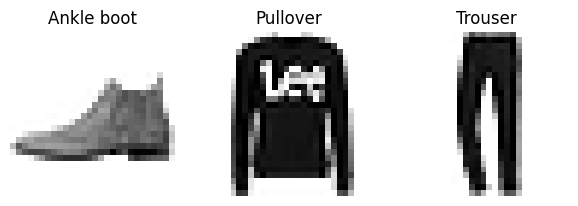

In [44]:
plt.figure(figsize=(7.2, 2.4))

# X_new(새로운 이미지 데이터)를 순차적으로 접근.
for index, image in enumerate(X_new):
    # 1행 3열의 서브플롯을 생성. index+1로 각 이미지가 위치할 서브플롯을 지정.
    plt.subplot(1, 3, index + 1)

    # 각 이미지를 이진 색상(binary)으로 표시하고, "nearest" 보간법을 사용하여 픽셀을 부드럽게 처리하지 않음.
    plt.imshow(image, cmap="binary", interpolation="nearest")

    # 축을 숨겨 이미지 외에 불필요한 정보가 보이지 않게 함.
    plt.axis('off')

    # 각 이미지에 대응하는 클래스 이름을 서브플롯의 제목으로 설정. 제목의 폰트 크기는 12.
    plt.title(class_names[y_test[index]], fontsize=12)

# 서브플롯 간 가로(wspace) 및 세로(hspace) 간격을 조정.
plt.subplots_adjust(wspace=0.2, hspace=0.5)

#save_fig('fashion_mnist_images_plot', tight_layout=False)

plt.show()


# 함수형 API
캘리포니아 주택 데이터셋으로 진행

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

뉴런 수를 30개에서 40개로 변경....

In [47]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

# 첫 번째 은닉층. Dense 층은 40개의 뉴런을 가지며, 활성화 함수로 ReLU(Rectified Linear Unit)를 사용.
hidden1 = keras.layers.Dense(40, activation="relu")(input_)

# 두 번째 은닉층. 첫 번째 은닉층(hidden1)의 출력을 입력으로 받아 40개의 뉴런을 가짐.
hidden2 = keras.layers.Dense(40, activation="relu")(hidden1)

# 입력층과 두 번째 은닉층의 출력을 연결(concatenate). 이는 네트워크의 skip connection을 구성하여,
# 입력 데이터를 직접 출력층에 전달하면서도 은닉층을 통과한 정보도 함께 사용.
concat = keras.layers.concatenate([input_, hidden2])

# 출력층. Dense 층은 1개의 뉴런을 가지며, 회귀(regression) 문제에서 사용되는 선형 활성화 함수를 기본으로 함.
# 값을 2로 올리니 다른 코드에 문제가 생기는 현상 발견...
output = keras.layers.Dense(1)(concat)

# 모델을 정의. 입력층은 input_, 출력층은 output으로 지정.
model = keras.models.Model(inputs=[input_], outputs=[output])

뉴런 수가 바뀌었는지 확인하기 위해 model.summary() 코드로 다시 확인...

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 40)                   360       ['input_1[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 40)                   1640      ['dense_3[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 48)                   0         ['input_1[0][0]',             
                                                                     'dense_4[0][0]']         

In [49]:
X_train.shape

(11610, 8)

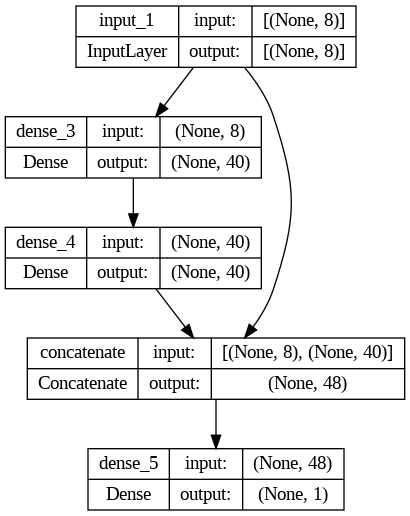

In [50]:
keras.utils.plot_model(model, "housing.png", show_shapes=True)

In [51]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 4s 4ms/step - loss: 2.1713 - val_loss: 1.2198
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7069 - val_loss: 0.7023
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6438 - val_loss: 0.6356
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6075 - val_loss: 0.5952
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5798 - val_loss: 0.5871
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5567 - val_loss: 0.5270
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5408 - val_loss: 0.5197
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5284 - val_loss: 0.6106
Epoch 9/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5143 - val_loss: 0.4861
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5041 - val_loss: 0.4934

In [52]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 53ms/step


array([[0.5699943],
       [1.5485144],
       [3.1810846]], dtype=float32)

와이드나 딥 경로에 다른 입력 특성을 전달하면 어떻게 될지 궁금해서 작성한 코드
(특성 0에서 4까지) 5개의 특성을 와이드 경로에 보내고 (특성 2에서 7까지) 6개의 특성을 딥 경로에 전달할 예정 
3개의 특성(특성 2, 3, 4)은 양쪽에 모두 전달

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

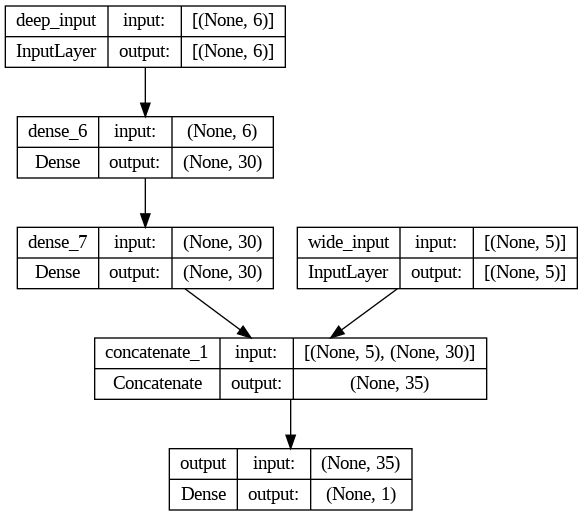

In [56]:
keras.utils.plot_model(model, "housing2.png", show_shapes=True)

In [57]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.7368 - val_loss: 1.8447
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7672 - val_loss: 1.0215
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6719 - val_loss: 0.7275
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6174 - val_loss: 0.6117
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5794 - val_loss: 0.5428
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5500 - val_loss: 0.5147
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5268 - val_loss: 0.5017
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5081 - val_loss: 0.4907
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4926 - val_loss: 0.4804
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4801 - val_loss: 0.4703

In [58]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
y_pred

1/1 [==============================] - 0s 50ms/step


array([[0.39715588],
       [1.9401858 ],
       [3.3560505 ]], dtype=float32)

# 저장과 복원

In [59]:
model.save("my_keras_model.keras")

In [60]:
model2 = keras.models.load_model("my_keras_model.keras")

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 deep_input (InputLayer)     [(None, 6)]                  0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 30)                   210       ['deep_input[0][0]']          
                                                                                                  
 wide_input (InputLayer)     [(None, 5)]                  0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 30)                   930       ['dense_6[0][0]']             
                                                                                            

In [62]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 deep_input (InputLayer)     [(None, 6)]                  0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 30)                   210       ['deep_input[0][0]']          
                                                                                                  
 wide_input (InputLayer)     [(None, 5)]                  0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 30)                   930       ['dense_6[0][0]']             
                                                                                            

In [63]:
model.layers

In [64]:
y_pred = model2.predict((X_new_A, X_new_B))
y_pred

1/1 [==============================] - 0s 62ms/step


array([[0.39715588],
       [1.9401858 ],
       [3.3560505 ]], dtype=float32)

# 훈련 과정에서 콜백 사용

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [67]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.keras") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 2.0230 - val_loss: 1.6497
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7176 - val_loss: 0.6643
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6466 - val_loss: 0.6338
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6033 - val_loss: 0.5609
Epoch 5/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5674 - val_loss: 0.5273
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5368 - val_loss: 0.5015
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5111 - val_loss: 0.4800
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4902 - val_loss: 0.4603
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4714 - val_loss: 0.4395
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4418


In [68]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 3s 4ms/step - loss: 0.4087 - val_loss: 0.6199
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3642 - val_loss: 1.3104
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3565 - val_loss: 0.3815
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3394 - val_loss: 0.3196
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3329 - val_loss: 0.8517
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3309 - val_loss: 2.2136
Epoch 7/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3374 - val_loss: 0.9872
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3162 - val_loss: 0.9944
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3153 - val_loss: 1.0687
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3151 - val_lo